In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pickle

In [210]:
img_loc = '4.jpg'

In [211]:
img = cv2.cvtColor(cv2.imread(img_loc), cv2.COLOR_BGR2RGB)

In [212]:
def display(img, cmap = None):
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')

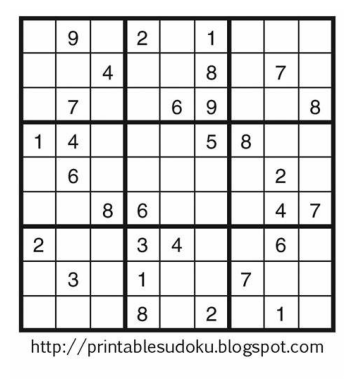

In [214]:
display(img)

In [215]:
height, width = 512, 512

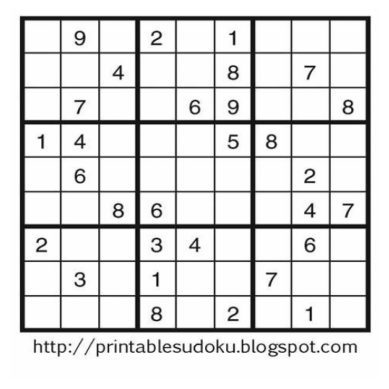

In [216]:
img = cv2.resize(img, (height, width))
display(img)

In [217]:
work_img = img.copy()
gray_img = cv2.cvtColor(work_img, cv2.COLOR_RGB2GRAY)
blur_img = cv2.GaussianBlur(gray_img, (7, 7), 1)
thresh_img = cv2.adaptiveThreshold(blur_img, 255, 1, 1, 11, 2)

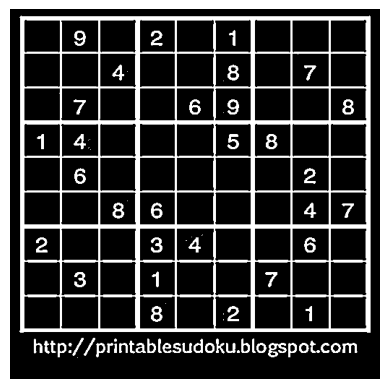

In [218]:
display(thresh_img, 'gray')

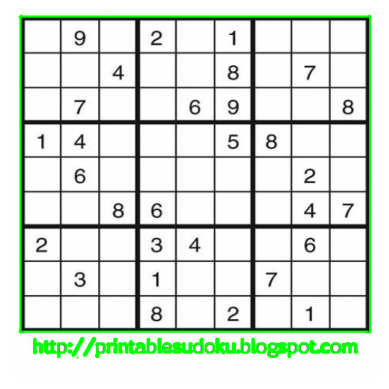

In [219]:
imgCnt = img.copy()
contours, heir = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(imgCnt, contours, -1, (0, 255, 0), 2)
display(imgCnt)

In [220]:
biggestCnt = None
maxArea = 0
four_pts = None

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 100000:
        peri = cv2.arcLength(cnt, True)
        corners = cv2.approxPolyDP(cnt, 0.02*peri, True)
        if area > maxArea and len(corners) == 4:
            biggestCnt = cnt
            four_pts = corners
            maxArea = area

In [221]:
biggestCnt

array([[[15,  9]],

       [[14, 10]],

       [[13, 11]],

       ...,

       [[18, 10]],

       [[17, 10]],

       [[16, 10]]], dtype=int32)

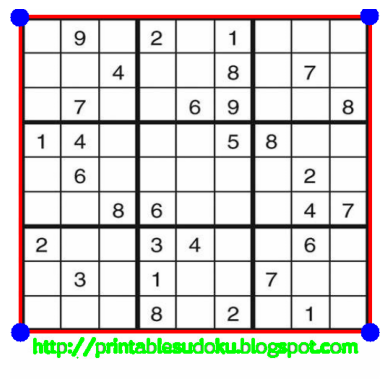

In [222]:
cv2.drawContours(imgCnt, biggestCnt, -1, (255, 0, 0), 3)
cv2.drawContours(imgCnt, four_pts, -1, (0, 0, 255), 25)
display(imgCnt)

In [223]:
four_pts = four_pts.reshape(4, 2,)

In [224]:
four_pts

array([[ 13,  11],
       [ 14, 447],
       [498, 447],
       [497,   9]], dtype=int32)

In [225]:
def ordered_corners(pts):
    rect = np.zeros((4, 2))

    s = np.sum(pts, axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    d = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(d)]
    rect[3] = pts[np.argmax(d)]

    return rect

In [226]:
rect = ordered_corners(four_pts)
rect = np.float32(rect)
print(rect)

[[ 13.  11.]
 [497.   9.]
 [498. 447.]
 [ 14. 447.]]


In [227]:
(tl, tr, br, bl) = rect
tl, tr, br, bl

(array([13., 11.], dtype=float32),
 array([497.,   9.], dtype=float32),
 array([498., 447.], dtype=float32),
 array([ 14., 447.], dtype=float32))

In [228]:
w1 = np.sqrt((tr[1] - tl[1])**2 + (tr[0] - tl[0])**2)
w2 = np.sqrt((br[1] - bl[1])**2 + (br[0] - bl[0])**2)
maxW = max(int(w1), int(w2))

h1 = np.sqrt((tr[1] - br[1])**2 + (tr[0] - br[0])**2)
h2 = np.sqrt((bl[1] - tl[1])**2 + (bl[0] - tl[0])**2)
maxH = max(int(h1), int(h2))

T = np.float32([
    [0, 0],
    [maxW-1, 0],
    [maxW-1, maxH-1],
    [0, maxH-1]
])

In [229]:
M = cv2.getPerspectiveTransform(rect, T)

In [230]:
warped_img_gray = cv2.warpPerspective(gray_img, M, (maxW, maxH))
# warped_img = cv2.warpPerspective(img, M, (maxW, maxH))
warped_img_gray = cv2.resize(warped_img_gray, (450, 450))
# warped_img = cv2.resize(warped_img, (450, 450))

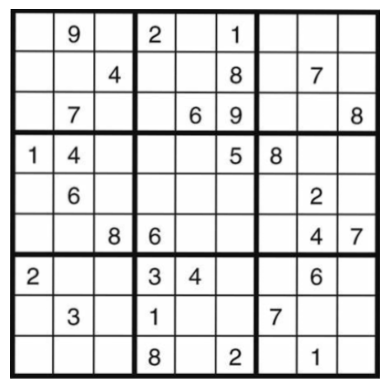

In [231]:
display(warped_img_gray, 'gray')

In [232]:
print(warped_img_gray.shape)

(450, 450)


In [233]:
sudoku = warped_img_gray.copy()

In [234]:
rows = np.vsplit(sudoku, 9)
grids = []
for row in rows:
    cols = np.hsplit(row, 9)
    for box in cols:
        grids.append(box)

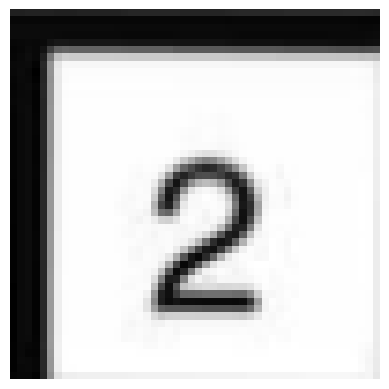

In [235]:
display(grids[3], 'gray')

In [236]:
grids = np.asarray(grids)
grids = grids.reshape(grids.shape[0], grids.shape[1], grids.shape[2], 1)
grids.shape

(81, 50, 50, 1)

In [237]:
small_img = []

for i in range(grids.shape[0]):
  img = grids[i]
  img = cv2.resize(grids[i], (32, 32))
  img = img / 255
  small_img.append(img)

small_img = np.asarray(small_img)
small_img = small_img.reshape(small_img.shape[0], small_img.shape[1], small_img.shape[2], 1)

print(small_img.shape)

(81, 32, 32, 1)


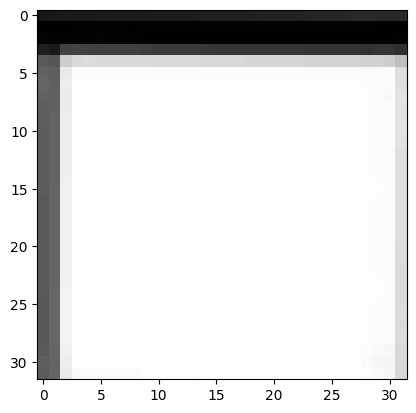

In [238]:
plt.imshow(small_img[4], 'gray')

In [239]:
model = None

In [240]:
#### UNCOMMENT THE BELOW LINE IF AND ONLY IF YOU HAVE UPLOADED "model_new.h5" INTO YOUR DRIVE AND RUNNING THIS ON COLAB
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# model = keras.models.load_model('/content/drive/MyDrive/model_new.h5')

In [241]:
model = keras.models.load_model("model_new.h5")

In [242]:
s = ""
cnt = 0

for img in small_img:
  cnt += 1
  sel_img = img[4:-4, 4:-4]
  ret, thresh = cv2.threshold(sel_img, 0.5, 255, cv2.THRESH_BINARY)
  sel_img = cv2.resize(thresh, (32, 32)).reshape(1, 32, 32, 1)
  probability = model.predict(sel_img.reshape(1, 32, 32, 1), verbose=0)
  class_pred = np.argmax(probability)
  s += str(int(class_pred))
  if cnt % 9 == 0 and cnt != 81:
    s += "\n"

In [243]:
print(s)

090201000
004008070
070069008
140005800
060000020
008600047
200340060
030100700
000802010


In [244]:
from utils import Processor
from solver import solver

In [245]:
org = solver.make_mat(s)
org = np.asarray(org)
copy = org.copy()

In [246]:
res = solver.solve(copy, 0, 0)
mask = copy - org

In [249]:
rec_img = np.zeros((9, 9, 50, 50, 3))

for i in range(grids.shape[0]):
    row, col = i // 9, i % 9
    if mask[row][col] > 0:
        masked = rec_img[row][col]
        rec_img[row][col] = cv2.putText(masked.astype(int), str(int(mask[row][col])), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 255, 0), 2)

In [251]:
result = cv2.hconcat(rec_img[0])

for i in range(1, 9):
    temp = cv2.hconcat(rec_img[i])
    result = np.concatenate((result, temp), axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


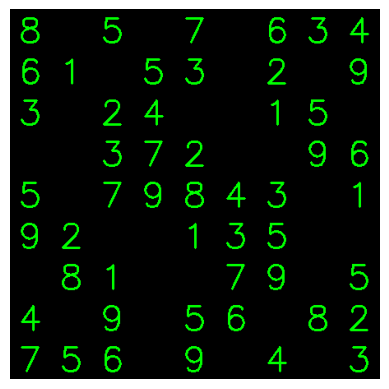

In [303]:
display(result)

In [300]:
rec_img2 = np.zeros((9, 9, 50, 50, 3))

for i in range(81):
    row, col = i // 9, i % 9
    if mask[row][col] == 0:
        masked = rec_img2[row][col]
        rec_img2[row][col] = cv2.putText(masked.astype(int), str(int(org[row][col])), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (255, 0, 0), 2)

In [301]:
result2 = cv2.hconcat(rec_img2[0])

for i in range(1, 9):
    temp = cv2.hconcat(rec_img2[i])
    result2 = np.concatenate((result2, temp), axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


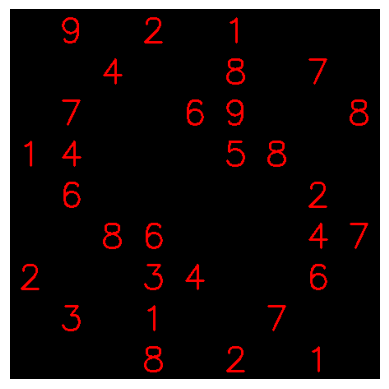

In [302]:
display(result2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


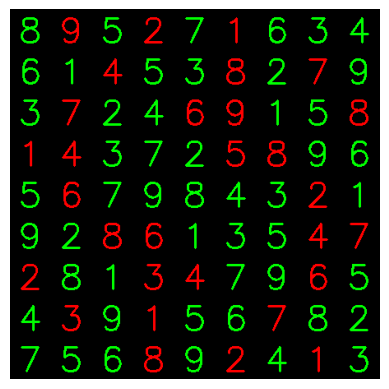

In [304]:
display(result + result2)